In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import random
import math
%matplotlib inline

In [2]:
images_dir = "./images"
# list of all digits
digits = list(map(str, range(10))) + ["ba", "pa"]
# map digits to their respective directory path
digits_dir = dict(zip(digits, map(lambda d: os.path.join(images_dir, d), digits)))

In [3]:
total_images = sum(len(glob.glob(os.path.join(folder, "*.jpg"))) for _, folder in digits_dir.items())
total_images

2033

In [19]:
im_width = im_height = 128
batch_size = 32
validation_split = 0.3

datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             validation_split=validation_split,
                             shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=10, 
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
                            )

train_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="training")
validation_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="validation")
train_steps_per_epoch = int(total_images * (1 - validation_split)) // batch_size
validation_steps_per_epoch = int(total_images * validation_split) // batch_size

Found 1430 images belonging to 12 classes.
Found 603 images belonging to 12 classes.


In [26]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Flatten
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=False):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    return _

input_img = Input(shape=(im_height, im_width, 3))
_ = conv_block(input_img, filters=32, bn=False)
_ = conv_block(_, filters=32*2)
_ = MaxPool2D()(_)
_ = conv_block(_, filters=32*3)
_ = MaxPool2D()(_)
_ = conv_block(_, filters=32*4)
_ = MaxPool2D()(_)
_ = conv_block(_, filters=32*5)
_ = MaxPool2D()(_)
_ = conv_block(_, filters=32*6)
_ = MaxPool2D()(_)
_ = GlobalMaxPool2D()(_)
# _ = Flatten()(_)
_ = Dense(units=128, activation="relu")(_)
_ = Dense(units=12, activation="softmax")(_)

model = Model(inputs=input_img, outputs=_)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 124, 124, 64)      256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 96)        55392     
_________________________________________________________________
batch_normalization_31 (Batc (None, 60, 60, 96)        384       
__________

In [27]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=20, 
                              validation_data=validation_gen, validation_steps=validation_steps_per_epoch)

Epoch 1/20
44/44 [==============================] - 43s 972ms/step - loss: 2.2022 - acc: 0.3103 - val_loss: 2.0727 - val_acc: 0.3599
Epoch 2/20
44/44 [==============================] - 17s 389ms/step - loss: 1.0666 - acc: 0.6676 - val_loss: 1.0189 - val_acc: 0.6866
Epoch 3/20
44/44 [==============================] - 17s 376ms/step - loss: 0.6589 - acc: 0.8014 - val_loss: 0.9717 - val_acc: 0.7148
Epoch 4/20
44/44 [==============================] - 17s 382ms/step - loss: 0.4743 - acc: 0.8690 - val_loss: 0.7453 - val_acc: 0.7695
Epoch 5/20
44/44 [==============================] - 17s 378ms/step - loss: 0.4148 - acc: 0.8719 - val_loss: 0.7294 - val_acc: 0.7711
Epoch 6/20
44/44 [==============================] - 17s 377ms/step - loss: 0.2749 - acc: 0.9272 - val_loss: 0.7466 - val_acc: 0.7662
Epoch 7/20
44/44 [==============================] - 17s 380ms/step - loss: 0.2853 - acc: 0.9163 - val_loss: 0.4744 - val_acc: 0.8541
Epoch 8/20
44/44 [==============================] - 17s 380ms/step - 

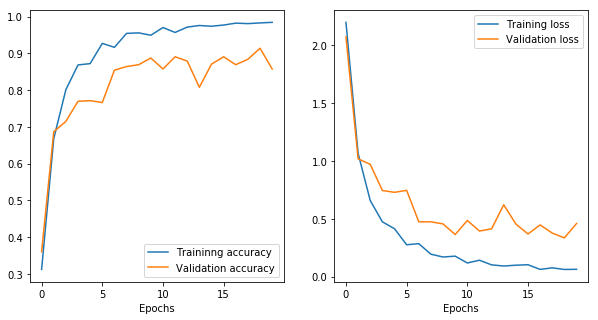

In [30]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['acc'], label='Traininng accuracy')
    axes[0].plot(history.history['val_acc'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

# Plot some predictions

In [63]:
X, Y_true = next(validation_gen)
Y_true = Y_true.argmax(axis=-1)
Y_pred = model.predict_on_batch(X).argmax(axis=-1)

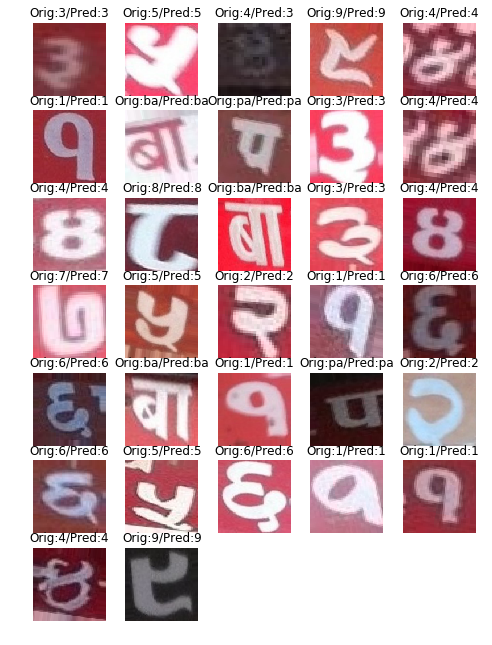

In [64]:
n_cols = 5
n_rows = math.ceil(len(X) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols+3, n_rows+4))
for i, (x, y_true, y_pred) in enumerate(zip(X, Y_true, Y_pred)):
    ax = axes.flat[i]
    ax.imshow(x, aspect='equal')
    ax.set_title("Orig:{}/Pred:{}".format(digits[y_true], digits[y_pred]))

for ax in axes.flat:
    ax.axis('off')

In [ ]:
fit.savefig("./predictions.png")